## Packages and Presets

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import torch
from skimpy import clean_columns
from sklearn.model_selection import train_test_split
from pickle import load

%load_ext blackcellmagic

In [2]:
SEED = 42
GRID_SIZE = 500

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

<span style="color:red">Conceptually, how does the model compare to Logistic Regression and MLPs (1 Pt)
Seperate MLP for every feature that get aggregated in the end. The model is a combination of multiple MLPs that are trained on different features. The output of each MLP is then aggregated to get the final output. This is different from Logistic Regression where the output is a linear combination of the input features.</span>

## Loading Data and Model

In [3]:
train_df = pd.read_csv("../data/heart_failure/train_val_split.csv").pipe(
    clean_columns
)
X_train = train_df.drop(columns=["heart_disease"], axis=1)
outlier_idx = X_train.query("resting_bp == 0").index
print(f"{outlier_idx=}")
X_train = X_train.drop(outlier_idx)
y_train = train_df["heart_disease"]
y_train = y_train[X_train.index]

# create categorical variable for cholesterol level
X_train["chol_level"] = pd.cut(
    X_train["cholesterol"],
    bins=[-1, 10, 200, 240, 1000],
    labels=["imputed", "normal", "borderline", "high"],
)

outlier_idx=Index([366], dtype='int64')


In [4]:
preprocessor = load(open("../models/preprocessor.pkl", "rb"))
model = torch.load("../models/neural_additive_model.pth")

In [5]:
categorical_cols = [col for col in X_train.columns if X_train.nunique()[col] < 5]
numeric_cols = [col for col in X_train.columns if col not in categorical_cols]

# preprocess data
X_train_preprocessed = preprocessor.fit_transform(X_train)

In [6]:
X_train.head()

,age,sex,chest_pain_type,resting_bp,cholesterol,fasting_bs,resting_ecg,max_hr,exercise_angina,oldpeak,st_slope,chol_level
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,high
1,37,M,ATA,130,283,0,ST,98,N,0.0,Up,high
2,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,borderline
3,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,normal
4,39,M,NAP,120,339,0,Normal,170,N,0.0,Up,high


In [7]:
pd.DataFrame(X_train_preprocessed).head()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,-1.435221,0.431739,0.838206,1.415918,-0.806973,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,-1.753660,-0.124829,0.783026,-1.506097,-0.806973,0.0,1.0,0.0,1.0,0.0,...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,-0.586050,0.320425,0.148452,-1.111230,0.579381,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,0.050829,0.988307,-0.026285,-0.558416,-0.806973,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,-1.541367,-0.681397,1.298042,1.336945,-0.806973,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


We can see that the first five columns in X_train_preprocessed are the numeric columns. To increase interpretability of the final plots, we will inverse transform the scales of these columns for the plots. Hence, the neural additive model will be fitted on the scaled data, but the plots will be based on the original, non scaled columns.

In [30]:
X_numeric = X_train_preprocessed[:, :5]
X_categorical = X_train_preprocessed[:, 5:]

# calculate 1st and 99th percentile for each numeric feature
percentiles = np.percentile(X_numeric, [0, 100], axis=0)
percentiles

# create one grid that will be passed as input to the model to get the logits of
# the different feature NNs and one grid to plot the logits afterwards
model_grids = []
plotting_grids = []
for i in range(X_numeric.shape[1]):
    model_grids.append(np.linspace(percentiles[0, i], percentiles[1, i], GRID_SIZE))
    plotting_grids.append(np.linspace(percentiles[0, i], percentiles[1, i], GRID_SIZE))


model_grids.append(
    np.array([[0] * (GRID_SIZE // 2) + [1] * (GRID_SIZE // 2)] * X_categorical.shape[1])
)

plotting_grids.extend([np.linspace(0, 1, GRID_SIZE)] * X_categorical.shape[1])

# model input grid
input = torch.tensor(np.row_stack(model_grids).T).float()
print(f"{input.shape=}")

# grid for plots
plotting_grids = np.row_stack(plotting_grids).T
print(f"{plotting_grids.shape=}")

In [9]:
pd.DataFrame(input.numpy()).head()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,-2.602831,-2.907669,-1.819645,-3.006591,-2.655445,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-2.592621,-2.894285,-1.809895,-2.995908,-2.640257,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-2.582410,-2.880900,-1.800146,-2.985225,-2.625069,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-2.572200,-2.867516,-1.790396,-2.974543,-2.609881,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-2.561989,-2.854131,-1.780646,-2.963860,-2.594693,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
# set model to eval mode to disable dropout
model.eval()
# get logits for each feature
feature_logits = model(input.to(DEVICE))[1].detach().cpu().numpy()


In [11]:
#feature_logits = model(torch.tensor(X_train_preprocessed).float().to(DEVICE))[1].detach().cpu().numpy()

In [12]:
# bring back the transformed data to the original scale
plotting_grids_backtrans = (
    np.c_[
        preprocessor.named_transformers_["numeric"]
        .inverse_transform(plotting_grids[:, :5]),
        plotting_grids[:, 5:]
    ]
)

print(f"{plotting_grids_backtrans.shape=}")

plotting_grids_backtrans.shape=(500, 25)


In [28]:
# get names of the transformed features
numeric_feature_names = preprocessor.named_transformers_[
    "numeric"
].get_feature_names_out()
categorical_feature_names = preprocessor.named_transformers_[
    "categorical"
].get_feature_names_out()
names = np.concatenate([numeric_feature_names, categorical_feature_names])
print(f"{names=}")

names=array(['age', 'resting_bp', 'cholesterol', 'max_hr', 'oldpeak', 'sex_F',
       'sex_M', 'chest_pain_type_ASY', 'chest_pain_type_ATA',
       'chest_pain_type_NAP', 'chest_pain_type_TA', 'fasting_bs_0',
       'fasting_bs_1', 'resting_ecg_LVH', 'resting_ecg_Normal',
       'resting_ecg_ST', 'exercise_angina_N', 'exercise_angina_Y',
       'st_slope_Down', 'st_slope_Flat', 'st_slope_Up',
       'chol_level_borderline', 'chol_level_high', 'chol_level_imputed',
       'chol_level_normal'], dtype=object)


We have to manually clean the names of the columns for the plots:

In [31]:
names_cleaned = [
    "Age",
    "Resting Blood Pressure",
    "Cholesterol",
    "Maximum Heart Rate",
    "Old Peak",
    "Sex Female",
    "Sex Male",
    "Chest Pain: Type Asymptomatic",
    "Chest Pain: Type Atypical Angina",
    "Chest Pain: Type Non-Anginal Pain",
    "Chest Pain: Type Typical Angina",
    "Fasting Blood Sugar < 120 mg/dl",
    "Fasting Blood Sugar > 120 mg/dl",
    "Resting ECG: Left Ventricular Hypertrophy",
    "Resting ECG: Normal",
    "Resting ECG: ST-T Wave Abnormality",
    "Exercise-Induced Angina: No",
    "Exercise-Induced Angina: Yes",
    "ST Slope: Downsloping",
    "ST Slope: Flat",
    "ST Slope: Upsloping",
    "Cholesterol Level: Borderline",
    "Cholesterol Level: High",
    "Cholesterol Level: Imputed",
    "Cholesterol Level: Normal"    
]

assert len(names_cleaned) == len(names)

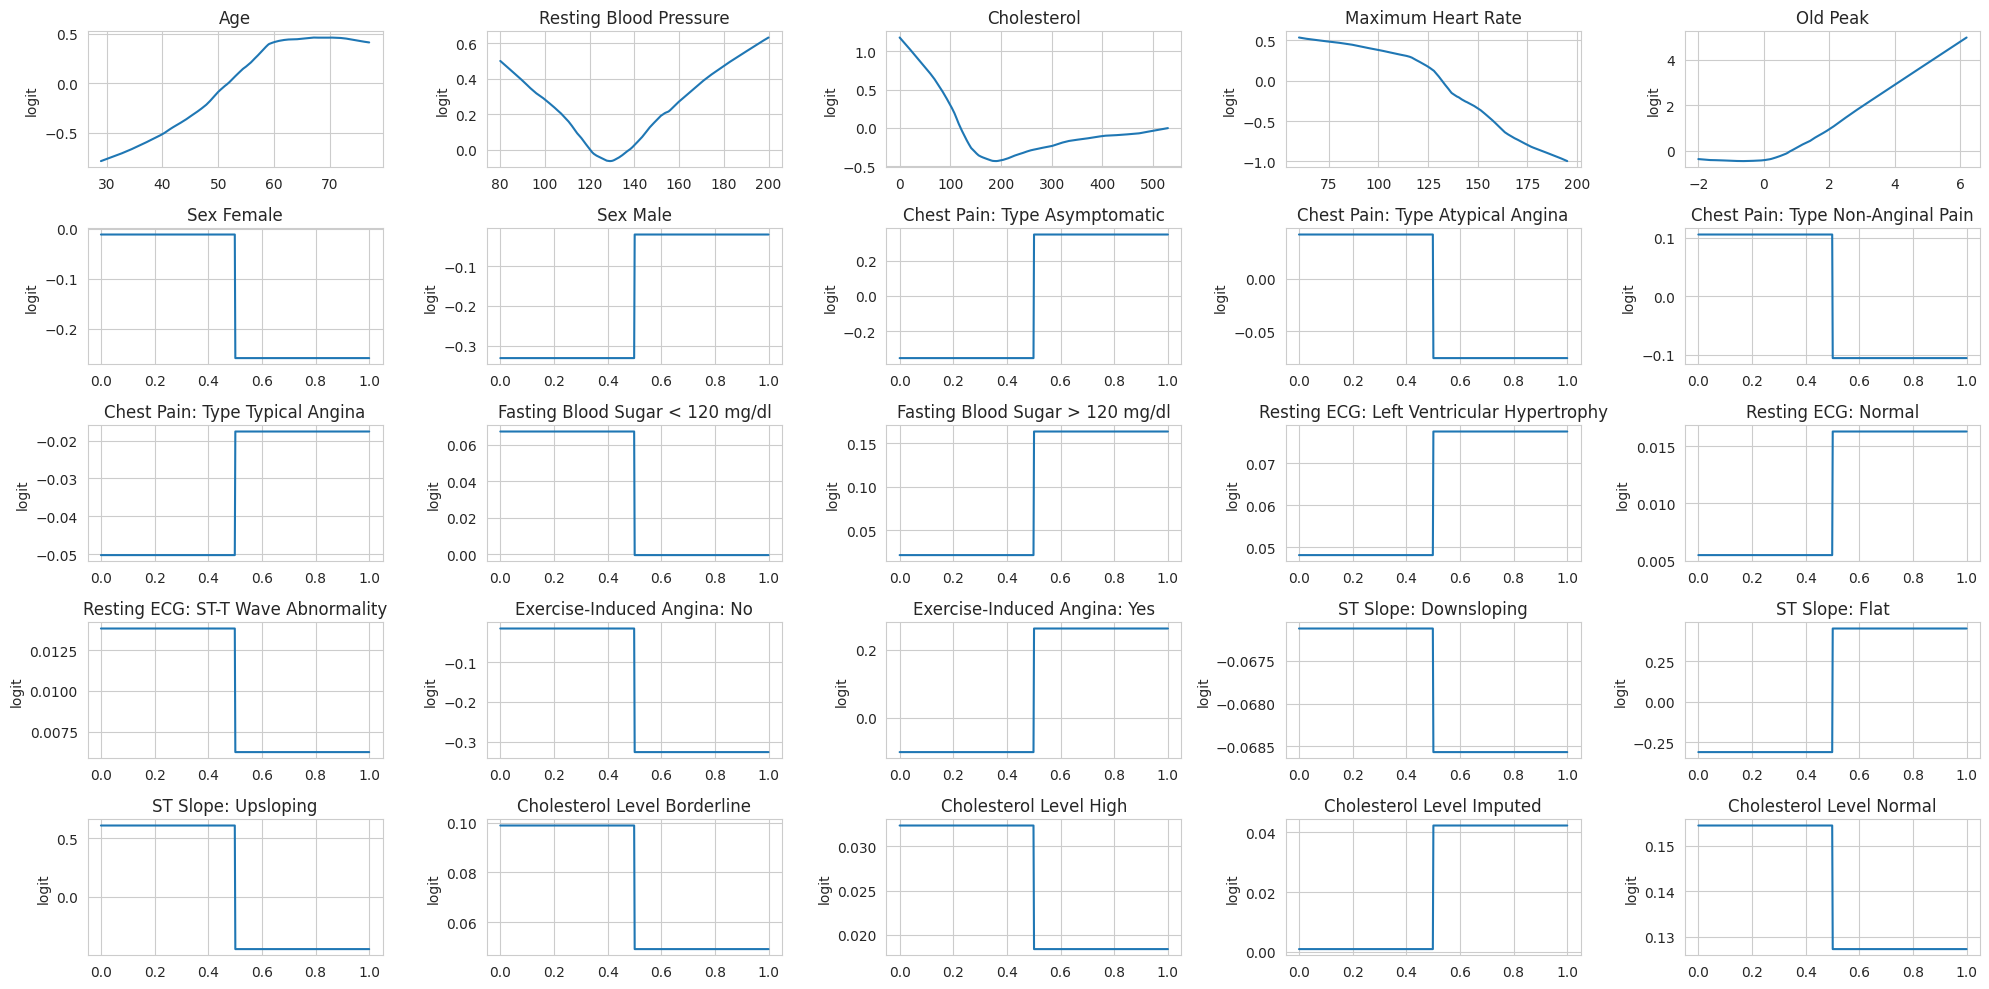

In [86]:
# plot every column vs the corresponding logits column
fig, axs = plt.subplots(5, 5, figsize=(20, 10))
axs = axs.flatten()
for i, ax in enumerate(axs):
    ax.plot(plotting_grids_backtrans[:, i], feature_logits[:, i])
    # if i < 5:
    #     # bring histogram to the sam escale as the lineplot:
    #     # see: https://stackoverflow.com/questions/57026223/how-to-re-scale-the-counts-in-a-matplotlib-histogram        
    #     counts, bins = np.histogram(X_train_preprocessed[:, i], bins=10)
    #     scale_factor = 1 / counts.max() * (feature_logits[:, i].max() - feature_logits[:, i].min())
        
        # color background of lineplot according to the density of the variable
        # X_train_preprocessed[:, i]
        
    
    # else:
    #     sns.countplot(x = X_train_preprocessed[:, i], ax = ax, width = 1.0, alpha=0.5, color="red")
    ax.set_title(f"{names_cleaned[i]}")
    ax.set_xlabel("")
    ax.set_ylabel("logit")
plt.tight_layout()
plt.show()
